In [1]:
import os
import sys
from pathlib import Path
# Setting the working directory to the root of the project
project_dir = Path("C:/Users/adbou/source/repos/KFHXRelatedAi/")
os.chdir(project_dir)

from Configs.GeneralPaths import SOURCEDATA
import pandas as pd
import numpy as np

In [2]:
#load user transactions data
user_transactions = pd.read_excel(Path(SOURCEDATA / "Transaction_User.xlsx"))

In [3]:
user_transactions.head()

,TrxId,FK_BusinessUserId,PointsRedeemed,FK_ContentId
0,12429817,976480,1000,113923
1,12525687,976480,10000,113853
2,12525666,976480,10000,113853
3,12838074,976921,10,113851
4,13587992,976480,50,113835


In [4]:
new_user_tranaction = user_transactions.drop(columns=['TrxId'])

In [5]:
new_user_tranaction.head()

,FK_BusinessUserId,PointsRedeemed,FK_ContentId
0,976480,1000,113923
1,976480,10000,113853
2,976480,10000,113853
3,976921,10,113851
4,976480,50,113835


In [6]:
#load deals data
deals_data = pd.read_excel(Path(SOURCEDATA / "Cleaned_Deals.xlsx"))
deals_data = deals_data.drop(columns=['Unnamed: 0'])
deals_data

,ContentId,Title,FK_StatusId,Deal Type,Description,Location,Points,Categories
0,113815,Off from Al Rifai,2,15 KD Voucher,Get a 15 KD discount voucher for your next onl...,https://www.google.com/maps/search/al+rifai+ku...,15000,F&B
1,113816,Off from Dip n dip,2,10 KD Voucher,Get 10 KD off on your next order from Dip n di...,NaN,10000,F&B
2,113817,Order from Dip n Dip and get discount,1,5KD discount,Order from Dip n Dip and get 5KD discount,https://www.google.com/maps/search/dipndip/@29...,5000,F&B
3,113818,Get discount from Ellena Bakery,2,3KD discount,Get 3KD discount from Ellena Bakery,https://maps.app.goo.gl/bnZXdfUbbaGFjFiJA,3000,F&B
4,113819,Off from Talabat,1,3 KD Voucher,Get 3KD discount from Talabat.,https://goo.gl/maps/5uoJEdD95W1YSpDt9,3000,F&B
...,...,...,...,...,...,...,...,...
195,115227,Roblox $10 USA Gift Card,1,Roblox Gift Card,Get a $10 Roblox USA Gift Card to be used for ...,NaN,3500,Entertainment
196,115229,Amazon $10 USA Gift Card,1,Amazon Gift Card,Get a $10 Amazon&nbsp;USA Gift Card to be used...,NaN,3500,Entertainment
197,115231,PlayStation Kuwait $10 Gift Card,1,PlayStation Kuwait Gift Card,Get a $10 PlayStation Kuwait&nbsp;Gift Card to...,NaN,3500,Entertainment
198,115244,Recharge your Deliveroo wallet with,2,10KD Wallet Recharge,Recharge your Deliveroo wallet with 10KD,https://www.instagram.com/deliveroo_kw/,1000,F&B


In [7]:
#merging deals data with user transaction data :
new_user_tranaction = new_user_tranaction.merge(deals_data[['ContentId', 'Categories']], left_on='FK_ContentId', right_on='ContentId', how='left')
new_user_tranaction = new_user_tranaction.drop(columns=['ContentId'])
new_user_tranaction

,FK_BusinessUserId,PointsRedeemed,FK_ContentId,Categories
0,976480,1000,113923,Health & Beauty
1,976480,10000,113853,Retail
2,976480,10000,113853,Retail
3,976921,10,113851,F&B
4,976480,50,113835,Travel
...,...,...,...,...
37946,1048474,5000,115099,Travel
37947,1056928,6000,115217,Entertainment
37948,1075249,3500,115231,Entertainment
37949,1110587,6000,115217,Entertainment


Some Explorations

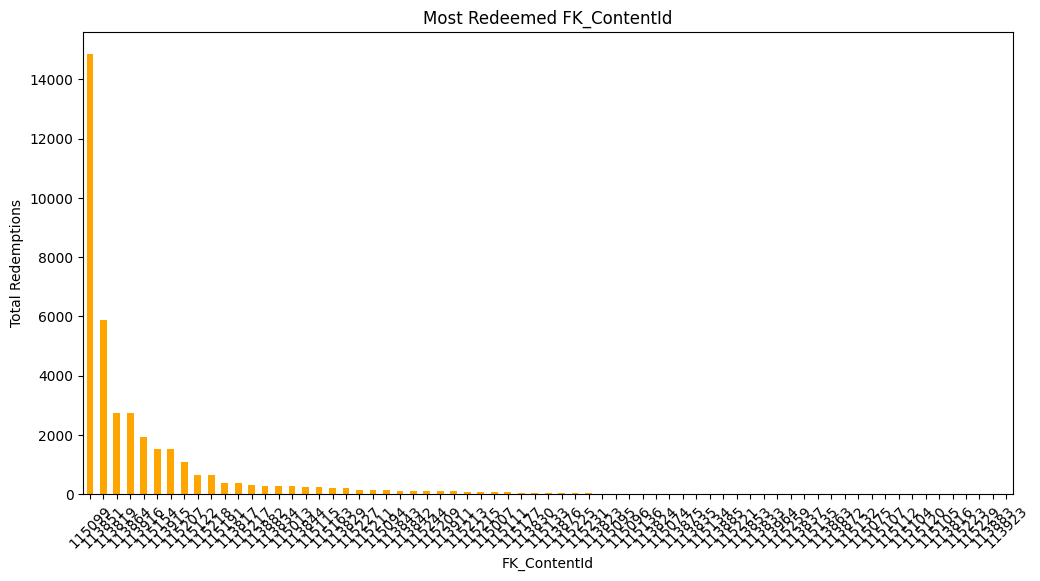

In [8]:
import matplotlib.pyplot as plt

# Counting the total number of redemptions for each FK_ContentId
content_total_redeems = new_user_tranaction['FK_ContentId'].value_counts()

# Plotting the most redeemed FK_ContentId
plt.figure(figsize=(12, 6))
content_total_redeems.plot(kind='bar', color='orange')
plt.xlabel('FK_ContentId')
plt.ylabel('Total Redemptions')
plt.title('Most Redeemed FK_ContentId')
plt.xticks(rotation=45)
plt.show()

count    25054.000000
mean         1.514768
std          1.201259
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         24.000000
Name: count, dtype: float64


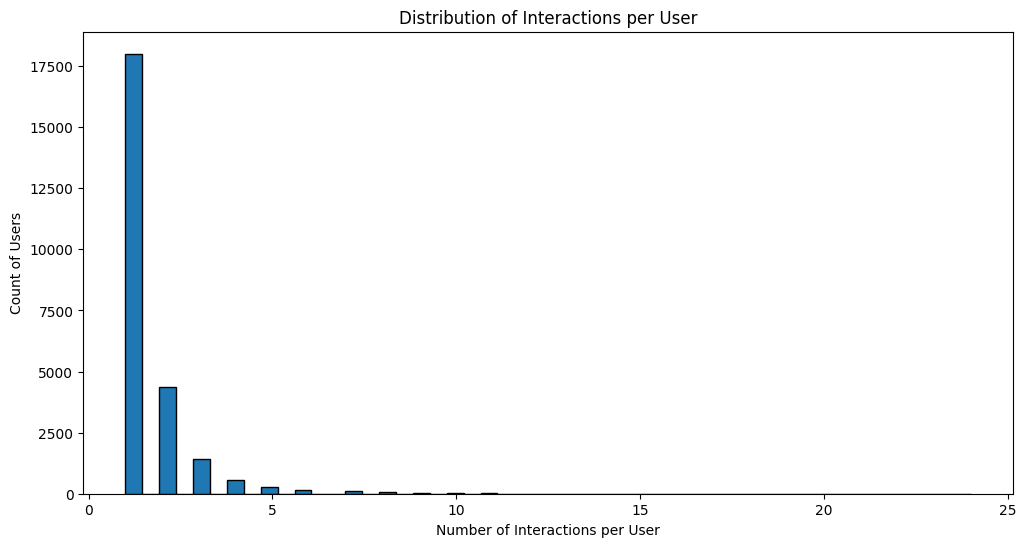

In [9]:
# Count the number of interactions per user
user_interaction_counts = new_user_tranaction['FK_BusinessUserId'].value_counts()

# Summary statistics
print(user_interaction_counts.describe())

# Plot the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(user_interaction_counts, bins=50, edgecolor='k')
plt.xlabel('Number of Interactions per User')
plt.ylabel('Count of Users')
plt.title('Distribution of Interactions per User')
plt.show()


Simple Collaborative Filtering

In [10]:
#testing SVD
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

# Add a column with binary values (1 if PointsRedeemed > 0)
new_user_tranaction['Redeemed'] = new_user_tranaction['PointsRedeemed'].apply(lambda x: 1 if x > 0 else 0)

# Pivot the DataFrame to create the user-item matrix
user_item_matrix = new_user_tranaction.pivot_table(index='FK_BusinessUserId', columns='FK_ContentId', values='Redeemed', fill_value=0)
user_item_matrix

FK_ContentId,113816,113817,113819,113823,113824,113829,113830,113833,113834,113835,...,115217,115218,115221,115223,115225,115227,115229,115231,115244,115259
FK_BusinessUserId,,,,,,,,,,,,,,,,,,,,,
976480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
976481,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
976482,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
976484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
976485,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1119351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1120134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Apply SVD
n_components = 14  # Number of latent factors
svd = TruncatedSVD(n_components=n_components)
latent_matrix = svd.fit_transform(user_item_matrix.values)

latent_matrix

array([[ 6.88583790e-02,  8.54997285e-01, -3.38082804e-01, ...,
        -6.60642633e-04, -3.77599037e-03, -8.91802500e-03],
       [ 2.16160266e-02,  1.48301983e-01, -2.43429650e-02, ...,
         1.85754999e-03, -5.63461464e-03,  2.99148889e-02],
       [ 7.33859726e-03,  2.00891436e-02, -6.13533164e-03, ...,
         2.55808084e-03, -4.01002039e-03,  2.95439184e-02],
       ...,
       [ 6.83467404e-02,  8.52571943e-01, -3.37083075e-01, ...,
        -3.36138569e-03, -3.60409429e-03, -8.00771467e-03],
       [ 6.83467404e-02,  8.52571943e-01, -3.37083075e-01, ...,
        -3.36138569e-03, -3.60409429e-03, -8.00771467e-03],
       [ 6.83467404e-02,  8.52571943e-01, -3.37083075e-01, ...,
        -3.36138569e-03, -3.60409429e-03, -8.00771467e-03]])

In [12]:
# Reconstruct the matrix
reconstructed_matrix = np.dot(latent_matrix, svd.components_)
reconstructed_matrix

array([[-1.04189915e-04, -2.85549139e-04, -1.29284292e-04, ...,
         1.43494731e-03,  5.37556616e-03,  3.29415376e-04],
       [-6.34745401e-05, -3.09169640e-04,  7.50202507e-04, ...,
        -3.71271670e-04,  6.67318056e-04, -3.68055529e-04],
       [-1.17117627e-06, -3.05388416e-04,  8.15539840e-04, ...,
         4.51260091e-05,  8.96487132e-05, -8.76529707e-06],
       ...,
       [-1.04241496e-04,  1.88407563e-04, -4.55939062e-04, ...,
         1.40332966e-03,  5.34015760e-03,  3.13445441e-04],
       [-1.04241496e-04,  1.88407563e-04, -4.55939062e-04, ...,
         1.40332966e-03,  5.34015760e-03,  3.13445441e-04],
       [-1.04241496e-04,  1.88407563e-04, -4.55939062e-04, ...,
         1.40332966e-03,  5.34015760e-03,  3.13445441e-04]])

In [13]:
# Evaluate the reconstruction
mse = mean_squared_error(user_item_matrix.values, reconstructed_matrix)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0015125602220079737


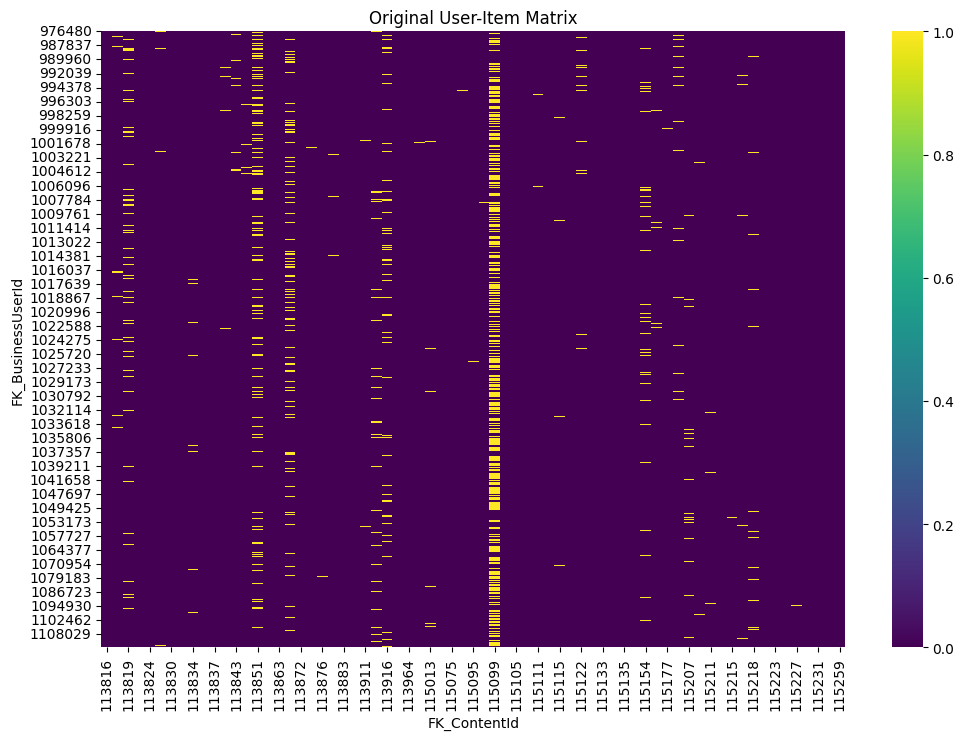

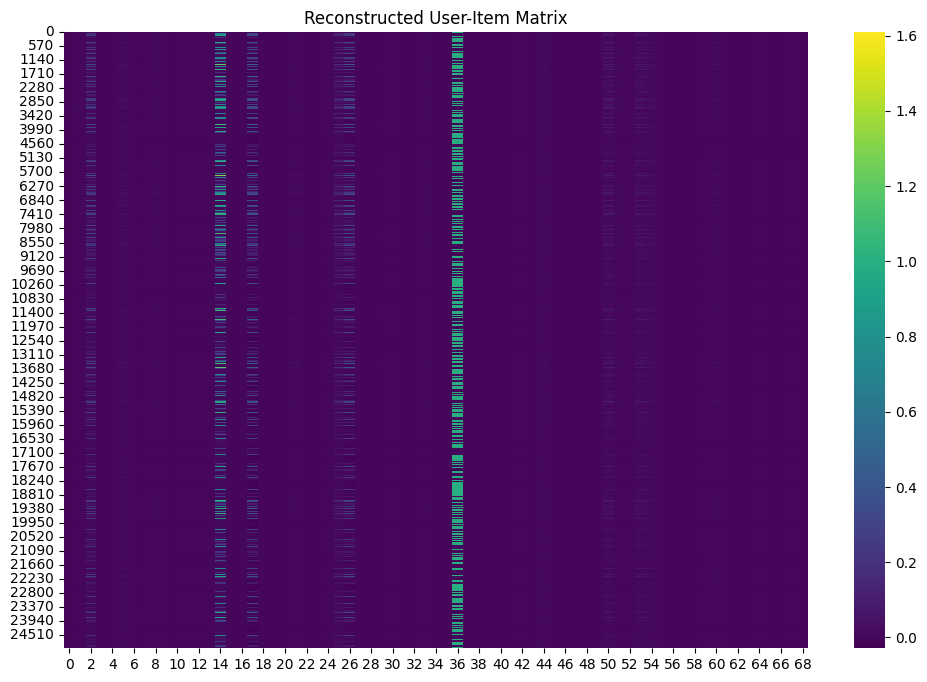

In [14]:
import seaborn as sns

# Plot heatmap for original user-item matrix
plt.figure(figsize=(12, 8))
sns.heatmap(user_item_matrix, cmap='viridis', cbar=True)
plt.title('Original User-Item Matrix')
plt.show()

# Plot heatmap for reconstructed matrix with the chosen number of components
n_components = 2
svd = TruncatedSVD(n_components=n_components)
latent_matrix = svd.fit_transform(user_item_matrix)
reconstructed_matrix = np.dot(latent_matrix, svd.components_)

plt.figure(figsize=(12, 8))
sns.heatmap(reconstructed_matrix, cmap='viridis', cbar=True)
plt.title('Reconstructed User-Item Matrix')
plt.show()


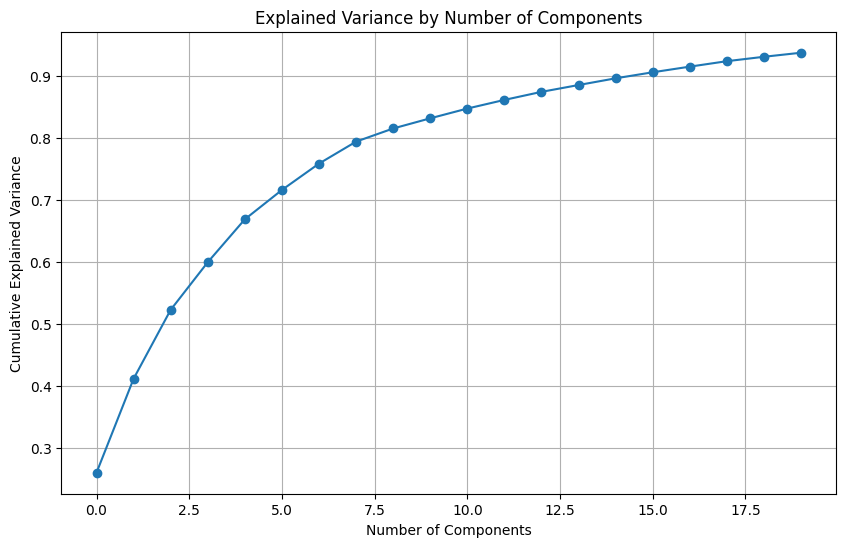

In [15]:
# Assuming user_item_matrix is already defined as a numpy array
n_components = 20
svd = TruncatedSVD(n_components=n_components)
svd.fit(user_item_matrix)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

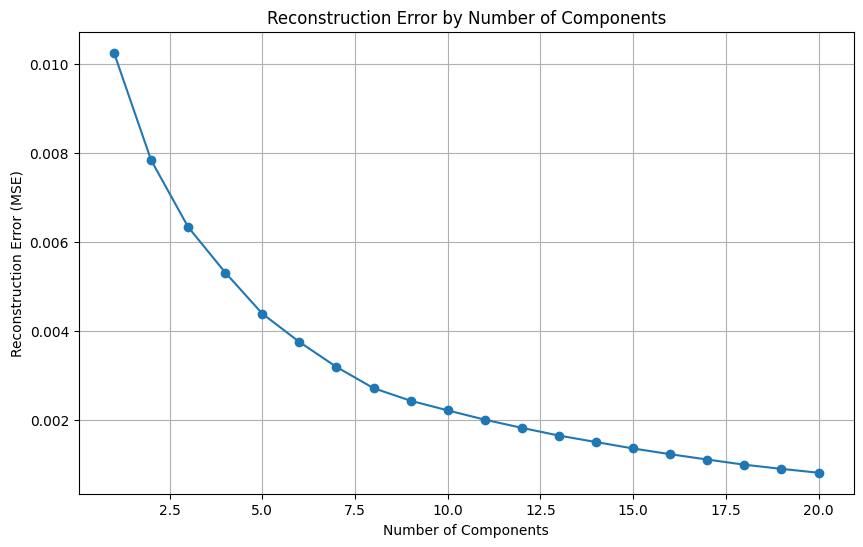

In [16]:
from sklearn.metrics import mean_squared_error

reconstruction_errors = []

for n in range(1, n_components + 1):
    svd = TruncatedSVD(n_components=n)
    latent_matrix = svd.fit_transform(user_item_matrix)
    reconstructed_matrix = np.dot(latent_matrix, svd.components_)
    mse = mean_squared_error(user_item_matrix, reconstructed_matrix)
    reconstruction_errors.append(mse)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), reconstruction_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error by Number of Components')
plt.grid(True)
plt.show()


In [17]:
reconstructed_matrix

array([[-1.04204733e-04, -4.83259263e-04,  2.63836194e-04, ...,
         1.48157742e-03,  5.56364073e-03,  2.78061422e-04],
       [-7.52165082e-05, -3.03063972e-04, -4.54105845e-04, ...,
        -1.15854664e-03, -2.76409308e-03, -6.73750686e-04],
       [-1.30322233e-05, -2.96092826e-04, -4.53835688e-04, ...,
        -7.41739378e-04, -3.35215507e-03, -3.15849170e-04],
       ...,
       [-1.04202005e-04,  1.12626411e-05, -5.74036362e-05, ...,
         1.44806859e-03,  5.52335576e-03,  2.64670027e-04],
       [-1.04202005e-04,  1.12626411e-05, -5.74036362e-05, ...,
         1.44806859e-03,  5.52335576e-03,  2.64670027e-04],
       [-1.04202005e-04,  1.12626411e-05, -5.74036362e-05, ...,
         1.44806859e-03,  5.52335576e-03,  2.64670027e-04]])

In [18]:
def recommend_items(user_id, user_item_matrix, reconstructed_matrix, num_recommendations=5):
    # Retrieving the index of the user in the original user item matrix
    user_index = user_item_matrix.index.get_loc(user_id)
    
    # Obtaining the user's scores from the reconstructed matrix of SVD
    user_scores = reconstructed_matrix[user_index]
    
    # Retrieving the indices of the items the user has already interacted with (Redeem = 1)
    interacted_items_indices = user_item_matrix.columns[user_item_matrix.iloc[user_index] > 0].tolist()
    
    # Creating a list of item scores with the item indices that the user interacted
    item_scores = list(enumerate(user_scores))
    
    # Filtering out items the user has already interacted with
    item_scores = [item for item in item_scores if item[0] not in interacted_items_indices]
    
    # Sorting the items by their score in descending order
    item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)
    
    # Retriveing the top N item indices
    top_item_indices = [item[0] for item in item_scores[:num_recommendations]]
    
    # Obtaining the actual item IDs recommended
    top_item_ids = user_item_matrix.columns[top_item_indices].tolist()
    
    return top_item_ids


user_id = user_item_matrix.index[4]  # Replace with actual user ID
recommendations = recommend_items(user_id, user_item_matrix, reconstructed_matrix, num_recommendations=5)
print(f"Top recommendations for user {user_id}: {recommendations}")


Top recommendations for user 976485: [113915, 113829, 115094, 113842, 115095]


In [19]:
user_trs = new_user_tranaction[new_user_tranaction["FK_BusinessUserId"] == 976485]
user_trs

,FK_BusinessUserId,PointsRedeemed,FK_ContentId,Categories,Redeemed
10,976485,1000,113883,On-demand,1
12,976485,3000,113915,On-demand,1
17,976485,3000,113915,On-demand,1
21,976485,100,113829,Automotive,1
21169,976485,3000,113915,On-demand,1


Incorporating Categories

In [20]:
new_user_tranaction

,FK_BusinessUserId,PointsRedeemed,FK_ContentId,Categories,Redeemed
0,976480,1000,113923,Health & Beauty,1
1,976480,10000,113853,Retail,1
2,976480,10000,113853,Retail,1
3,976921,10,113851,F&B,1
4,976480,50,113835,Travel,1
...,...,...,...,...,...
37946,1048474,5000,115099,Travel,1
37947,1056928,6000,115217,Entertainment,1
37948,1075249,3500,115231,Entertainment,1
37949,1110587,6000,115217,Entertainment,1


In [21]:
# Creating a pivot table for user-item interactions
user_item_matrix = new_user_tranaction.pivot_table(index='FK_BusinessUserId', columns='FK_ContentId', values='Redeemed', fill_value=0)

# Creating a pivot table for user-category interactions
user_category_matrix = new_user_tranaction.pivot_table(index='FK_BusinessUserId', columns='Categories', values='Redeemed', aggfunc='sum', fill_value=0)

# Combining the user-item and user-category matrices
combined_matrix = pd.concat([user_item_matrix, user_category_matrix], axis=1).fillna(0)

combined_matrix


,113816,113817,113819,113823,113824,113829,113830,113833,113834,113835,...,115244,115259,Automotive,Electronics,Entertainment,F&B,Health & Beauty,On-demand,Retail,Travel
FK_BusinessUserId,,,,,,,,,,,,,,,,,,,,,
976480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0,0,0,3,1,0,2,1
976481,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,1,0,0
976482,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,0,0,0
976484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,1,0,0,0,0
976485,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,2,0,0,0,0
1119351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,2,0,0,0,0
1120134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,1,0,0,0,0


In [22]:
# Applying SVD algoritm
n_components = 14  # Number of latent factors (this is based on the graphs above between 10 and 15 is ideal)
svd = TruncatedSVD(n_components=n_components)
latent_matrix = svd.fit_transform(combined_matrix.values)
reconstructed_matrix = np.dot(latent_matrix, svd.components_)
reconstructed_matrix

array([[-1.66730738e-05,  6.63323777e-02,  1.44330799e-02, ...,
        -4.67315852e-03,  3.73976022e-03,  1.00529933e+00],
       [-7.66279583e-05,  3.72065793e-04,  1.87774974e-02, ...,
         1.19483033e+00, -1.45400596e-03, -4.40240471e-04],
       [-2.93688791e-05,  2.70138859e-03,  1.51416078e-03, ...,
         3.65563024e-03, -1.48032483e-03, -8.82722678e-05],
       ...,
       [-1.55540461e-04, -8.50344009e-03, -3.63423865e-03, ...,
        -6.33644661e-03,  8.70494377e-04, -7.32241501e-05],
       [-1.55540461e-04, -8.50344009e-03, -3.63423865e-03, ...,
        -6.33644661e-03,  8.70494377e-04, -7.32241501e-05],
       [-1.55540461e-04, -8.50344009e-03, -3.63423865e-03, ...,
        -6.33644661e-03,  8.70494377e-04, -7.32241501e-05]])

In [27]:
def recommend_items(user_id, combined_matrix, reconstructed_matrix, original_data, num_recommendations=5):
    # Get the index of the user
    user_index = combined_matrix.index.get_loc(user_id)
    
    # Get the user's scores from the reconstructed matrix
    user_scores = reconstructed_matrix[user_index]

    # Extracting the original item and category columns
    item_columns = original_data['FK_ContentId'].unique()
    category_columns = original_data['Categories'].unique()

    # Separating the item scores and category scores
    item_scores = user_scores[:len(item_columns)]
    category_scores = user_scores[len(item_columns):]

    # Getting the indices of items the user has already interacted with
    interacted_items_indices = combined_matrix.iloc[user_index, :len(item_columns)][combined_matrix.iloc[user_index, :len(item_columns)] > 0].index.tolist()

    # Creating a list of item scores with the item indices
    item_scores = list(enumerate(item_scores))
    
    # Filtering out items the user has already interacted with
    item_scores = [item for item in item_scores if combined_matrix.columns[item[0]] not in interacted_items_indices]
    
    # Sorting items by score in descending order
    item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)

    # Getting the top N item indices
    top_item_indices = [item[0] for item in item_scores[:num_recommendations]]
    
    # Getting the actual item IDs
    top_item_ids = combined_matrix.columns[top_item_indices].tolist()

    return top_item_ids

# Example usage
user_id = combined_matrix.index[183]  # Replace with actual user ID
recommendations = recommend_items(user_id, combined_matrix, reconstructed_matrix, new_user_tranaction, num_recommendations=5)
print(f"Top recommendations for user {user_id}: {recommendations}")


Top recommendations for user 985749: [113915, 115013, 113911, 113842, 115227]


In [28]:
user_trs = new_user_tranaction[new_user_tranaction["FK_BusinessUserId"] == 985749]
user_trs

,FK_BusinessUserId,PointsRedeemed,FK_ContentId,Categories,Redeemed
12596,985749,10,113851,F&B,1
12610,985749,5000,113864,F&B,1
